In [1]:
import numpy as np
import pandas as pd 
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import csv

# Data Preparation

In [2]:
def load_data(in_path, name):
    df = pd.read_csv(in_path, low_memory=False)
    #print(f"{name}: shape is {df.shape}")
    #print(df.info())
    #display(df.head(5))
    return df

## Load Roster Data 

All files needed for analysis have been hosted at:
https://drive.google.com/drive/folders/1o3ZpOyUBJUFi4M8n_2d_yxEQlzSoRJQk?usp=sharing

In [3]:
DATA_DIR = "C:/Users/travis/Dropbox (Arthroscopy Associa)/Travis/Desktop/IU Big Data Application/Final Project Data"
datasets={}

In [4]:
reg_roster_2016 = load_data(os.path.join(DATA_DIR, f'reg_roster_2016.csv'), 'reg_roster_2016')
reg_roster_2016['Made_Roster'] = 0

post_roster_2016 = load_data(os.path.join(DATA_DIR, f'post_roster_2016.csv'), 'post_roster_2016')
post_roster_2016['Made_Roster'] = 1

roster_2016 = post_roster_2016.append(reg_roster_2016)

In [5]:
years = [2017, 2018]

In [6]:
roster_all = roster_2016.copy()

for ii in years:
    pre_name = 'reg_roster_' + str(ii)
    pre_df = load_data(os.path.join(DATA_DIR, f'{pre_name}.csv'), pre_name)
    #print(pre_df.shape)
    
    reg_name = 'post_roster_' + str(ii)
    reg_df = load_data(os.path.join(DATA_DIR, f'{reg_name}.csv'), reg_name)
    
    roster_df = pre_df.assign(Made_Roster=pre_df.gsis_id.isin(reg_df.gsis_id).astype(int))
    
    roster_all = roster_all.append(roster_df)
    #print(roster_all.shape)
    
roster_all = roster_all.drop(['season_type'], axis=1)

## Transform Play-By-Play Data 

In [7]:
years.append(2016)

In [8]:
columns = ['game_id', 'yardline_100', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'drive', 'qtr', 'down', 
           'goal_to_go', 'ydstogo', 'ydsnet', 'play_type', 'yards_gained','air_yards', 'yards_after_catch', 
           'two_point_converted', 'two_point_failed', 'third_down_converted', 'third_down_failed',
           'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass', 'interception', 'penalty', 'fumble_lost',
           'touchdown', 'fumble', 'complete_pass', 'passer_player_id', 'receiver_player_id', 'rusher_player_id',
           'fumbled_1_player_id', 'penalty_player_id', 'penalty_yards',
           'unique_id', 'season', 'Two_Min', 'Redzone', 'Per_Yards_Gained', 'Success_Play']

In [9]:
pbp_all = pd.DataFrame(columns = columns)

for ii in years:
    pbp_name = 'reg_pbp_' + str(ii)
    pbp_df = load_data(os.path.join(DATA_DIR, f'{pbp_name}.csv'), pbp_name)
    
    #get unique ID for each play
    pbp_df['unique_id'] = pbp_df['play_id'].astype(str) + pbp_df['game_id'].astype(str)
    
    #add year of game
    pbp_df['season'] = ii
    
    #keep plays we are concerned with
    pbp_df = pbp_df[(pbp_df.play_type == 'pass') | (pbp_df.play_type == 'run')]
    
    #encode two point conversions
    two_conv_df = pbp_df[(pbp_df.two_point_conv_result == 'success')]
    pbp_df = pbp_df.assign(two_point_converted=pbp_df.unique_id.isin(two_conv_df.unique_id).astype(int))
    
    two_fail_df = pbp_df[(pbp_df.two_point_conv_result == 'failure')]
    pbp_df = pbp_df.assign(two_point_failed=pbp_df.unique_id.isin(two_fail_df.unique_id).astype(int))
    
    #flag plays in last two mins of a half
    two_min_df = pbp_df[(pbp_df.half_seconds_remaining <= 120)]
    pbp_df = pbp_df.assign(Two_Min=pbp_df.unique_id.isin(two_min_df.unique_id).astype(int))
    
    #flag red zone plays
    red_df = pbp_df[(pbp_df.yardline_100 <= 20)]
    pbp_df = pbp_df.assign(Redzone=pbp_df.unique_id.isin(red_df.unique_id).astype(int))
    
    
    # flag success rate using Football Outsider's varsity formula
    # https://www.footballoutsiders.com/info/glossary
    pbp_df['Per_Yards_Gained'] = pbp_df.yards_gained / pbp_df.ydstogo
    
    suc_fir_df = pbp_df[(pbp_df.down == 1) & (pbp_df.Per_Yards_Gained >= .5)]
    suc_sec_df = pbp_df[(pbp_df.down == 2) & (pbp_df.Per_Yards_Gained >= .7)]
    suc_thi_df = pbp_df[(pbp_df.down == 3) & (pbp_df.Per_Yards_Gained >= 1)]
    suc_fou_df = pbp_df[(pbp_df.down == 4) & (pbp_df.Per_Yards_Gained >= 1)]
    
    suc_all_df = pd.concat([suc_fir_df, suc_sec_df, suc_thi_df, suc_fou_df], axis=0, ignore_index=True)
    
    pbp_df = pbp_df.assign(Success_Play=pbp_df.unique_id.isin(suc_all_df.unique_id).astype(int))
    
    
    #prepare final dataframe
    pbp_df = pbp_df.fillna(0)
    
    pbp_all = pbp_all.append(pbp_df[columns])

## Combine All Data 

In [10]:
agg_cols = ['yards_gained', 'two_point_converted', 'two_point_failed', 'third_down_converted', 'third_down_failed',
            'fourth_down_converted', 'fourth_down_failed', 'touchdown', 'Two_Min', 'Redzone', 'Success_Play', 'Total_Plays',
            'Q1_Plays', 'Q2_Plays', 'Q3_Plays', 'Q4_Plays']

pass_cols = ['interception', 'incomplete_pass', 'complete_pass', 'air_yards', 'pass_yards', 'pass_touchdown', 
             'Success_Pass', 'Passer_Plays'] + agg_cols

rec_cols = ['yards_after_catch', 'receiving_yards', 'receiving_touchdown', 'Success_Receive', 'Receiver_Plays'] + agg_cols

rush_cols = ['rush_yards', 'rush_touchdown', 'Success_Rush', 'Run_Plays'] + agg_cols

pen_cols = ['penalty', 'penalty_yards']

fumb_cols = ['fumble_lost', 'fumble']

In [11]:
all_cols = pass_cols + rec_cols + rush_cols + pen_cols + fumb_cols
all_cols = list(set(all_cols))
all_cols = sorted(all_cols, key=str.lower)

In [12]:
stats_df = pd.DataFrame(columns = all_cols)

for ii in years:
    year_df = pbp_all[(pbp_all.season == ii)].copy()
    year_df['Total_Plays'] = 1
    
    #Add Plays in quarter    
    q1_df = year_df[(year_df.qtr == 1)]
    year_df = year_df.assign(Q1_Plays=year_df.unique_id.isin(q1_df.unique_id).astype(int))
    
    q2_df = year_df[(year_df.qtr == 2)]
    year_df = year_df.assign(Q2_Plays=year_df.unique_id.isin(q2_df.unique_id).astype(int))
    
    q3_df = year_df[(year_df.qtr == 3)]
    year_df = year_df.assign(Q3_Plays=year_df.unique_id.isin(q3_df.unique_id).astype(int))
    
    q4_df = year_df[(year_df.qtr == 4)]
    year_df = year_df.assign(Q4_Plays=year_df.unique_id.isin(q4_df.unique_id).astype(int))
    
    #assemble passing stats
    pass_df = year_df[(year_df.play_type == 'pass')]
    pass_df = pass_df.infer_objects()  
    pass_df['pass_yards'] = pass_df['yards_gained']
    pass_df['pass_touchdown'] = pass_df['touchdown']
    pass_df['Success_Pass'] = pass_df['Success_Play']
    pass_df['Passer_Plays'] = 1
    
    pass_df = pass_df.groupby('passer_player_id').sum()    
    pass_df = pass_df[pass_cols]
    pass_df.index.name = 'player_id'
    
    
    #assemble receiving stats
    rec_df = year_df[(year_df.play_type == 'pass')]
    rec_df = rec_df.infer_objects()
    rec_df['receiving_yards'] = rec_df['yards_gained']
    rec_df['receiving_touchdown'] = rec_df['touchdown']
    rec_df['Success_Receive'] = rec_df['Success_Play']
    rec_df['Receiver_Plays'] = 1
    
    rec_df = rec_df.groupby('receiver_player_id').sum()    
    rec_df = rec_df[rec_cols]
    
    rec_df.index.name = 'player_id'
    rec_df = rec_df.drop(rec_df.index[0])
    
    
    #assemble rushing stats
    rush_df = year_df[(year_df.play_type == 'run')]
    rush_df = rush_df.infer_objects()
    rush_df['rush_yards'] = rush_df['yards_gained']
    rush_df['rush_touchdown'] = rush_df['touchdown']
    rush_df['Success_Rush'] = rush_df['Success_Play']
    rush_df['Run_Plays'] = 1
    
    rush_df = rush_df.groupby('rusher_player_id').sum()    
    rush_df = rush_df[rush_cols]
    
    rush_df.index.name = 'player_id'
    
    
    #assemble penalty stats
    pen_df = year_df[(year_df.penalty == 1)]
    pen_df = pen_df.infer_objects()
    pen_df = pen_df.groupby('penalty_player_id').sum()    
    pen_df = pen_df[pen_cols]
    
    pen_df.index.name = 'player_id'
    pen_df = pen_df.drop(pen_df.index[0])
    
    
    #assemble fumble stats
    fumb_df = year_df[(year_df.fumble == 1)]
    fumb_df = fumb_df.infer_objects()
    
    fumb_df = fumb_df.groupby('fumbled_1_player_id').sum()    
    fumb_df = fumb_df[fumb_cols]
    
    fumb_df.index.name = 'player_id'
    
    
    #combine stats
    comb_df = pd.concat([pass_df, rec_df, rush_df, pen_df, fumb_df]).groupby(['player_id']).sum()
    
    
    #join in player information
    player_df = roster_all[(roster_all.season == ii)]
    
    player_df = player_df.set_index('gsis_id')
    player_df.index.name = 'player_id'
    
    comb_df = comb_df.join(player_df)    
    comb_df = comb_df.dropna(subset=['Made_Roster'])
    
    
    #join all data into final dataframe
    comb_df = comb_df.fillna(0)
   
    stats_df = stats_df.append(comb_df)

C:\Users\travis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:83: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\travis\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [13]:
#change the display formats on numbers for simplicity
pd.options.display.float_format = '{:,.0f}'.format
stats_df['season'] = pd.to_numeric(stats_df['season'], downcast='integer')

In [14]:
print(len(stats_df))
stats_df.head()

1730


,Made_Roster,Passer_Plays,Q1_Plays,Q2_Plays,Q3_Plays,Q4_Plays,Receiver_Plays,Redzone,Run_Plays,Success_Pass,...,rush_yards,season,team,third_down_converted,third_down_failed,touchdown,two_point_converted,two_point_failed,yards_after_catch,yards_gained
00-0019596,1,614,160,186,144,138,0,102,14,292,...,39,2017,NE,68,94,35,2,0,0,"4,393"
00-0020531,1,552,129,157,137,145,0,90,16,263,...,32,2017,NO,59,99,26,0,0,0,"4,225"
00-0021206,0,430,87,130,111,120,0,51,23,178,...,138,2017,NYJ,64,87,25,0,1,0,"2,800"
00-0021429,0,289,65,87,44,94,0,43,8,123,...,18,2017,ARI,33,54,11,0,1,0,"1,837"
00-0021547,0,0,7,21,12,13,53,12,0,0,...,0,2017,LAC,4,11,3,0,1,66,316


## Visualizations 

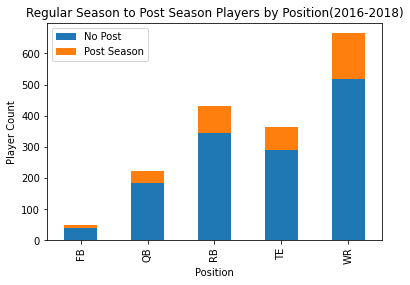

In [20]:

ax = stats_df.groupby(['position', 'Made_Roster']).size().unstack().plot(kind='bar', stacked=True)
ax.set_ylabel('Player Count')
ax.set_xlabel('Position')
ax.set_title('Regular Season to Post Season Players by Position(2016-2018)')
ax.legend(['No Post', 'Post Season'])

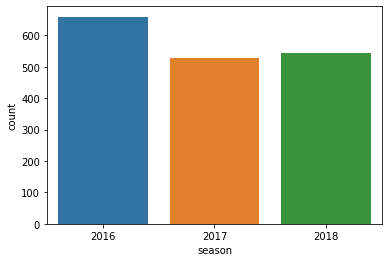

In [16]:
sns.countplot(x="season", data=stats_df);

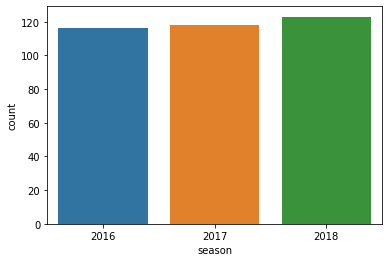

In [17]:
sns.countplot(x="season", data=stats_df[stats_df['Made_Roster'] == 1]);

C:\Users\travis\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\travis\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\travis\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax

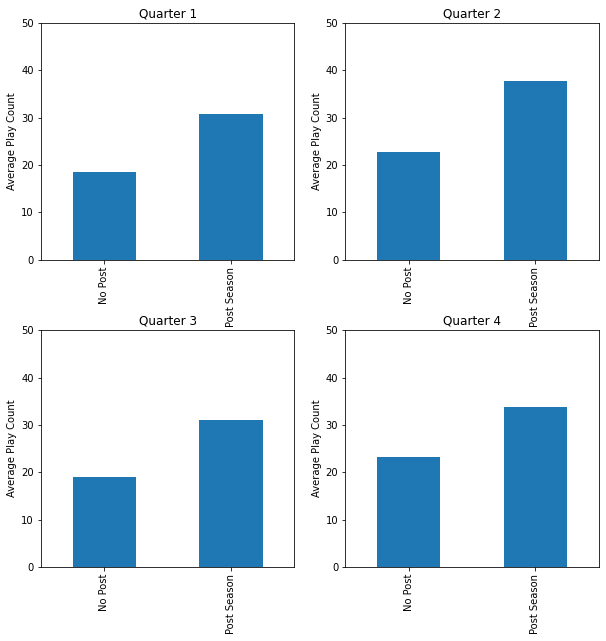

In [21]:
f = plt.figure(figsize=(10,10))

quarters = [1, 2, 3, 4]
for ii, jj in enumerate(quarters):
    plt.subplot(2,2,ii+1).set_ylim(0, 50)
    plt.title("Quarter " + str(jj))
    stats_df['Q' + str(jj) + '_Plays'].groupby(stats_df['Made_Roster']).mean().plot(kind='bar')
    plt.ylabel('Average Play Count')
    plt.xlabel('')
    plt.xticks([0,1], ['No Post', 'Post Season'])
    
f.subplots_adjust(hspace = .3)

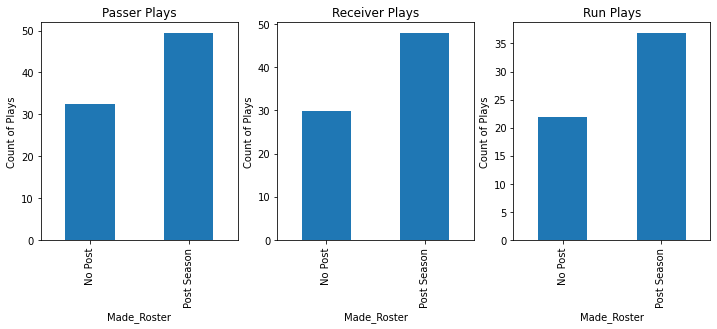

In [24]:
f = plt.figure(figsize=(12,4))

quarters = ['Passer', 'Receiver', 'Run']
for ii, jj in enumerate(quarters):
    plt.subplot(1,3,ii+1)
    plt.title(str(jj) + ' Plays')
    plt.ylabel('Count of Plays')
    plt.xlabel(' ')
    stats_df[str(jj) + '_Plays'].groupby(stats_df['Made_Roster']).mean().plot(kind='bar')
    plt.xticks([0,1], ['No Post', 'Post Season'])

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from statistics import mean

import warnings
warnings.filterwarnings('ignore')

In [26]:
X = stats_df.copy()
y = stats_df[['Made_Roster']]

ohe_df = pd.get_dummies(X.position)
X = pd.concat([X, ohe_df], axis=1).drop(columns=['Made_Roster',
                                                      'full_player_name', 'abbr_player_name', 'team', 'position', 'season'])

feature_names = list(X)

In [27]:
score = []

for ii in range(1, 31):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=ii)
    
    logreg = LogisticRegression(solver='saga')
    logreg.fit(X_train, y_train)
    score.append(logreg.score(X_test, y_test))
    
mean(score)

0.7817597944765575

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

model_ftest = SelectKBest(score_func=f_classif, k='all')
model_ftest.fit(X_train, y_train)

SelectKBest(k='all', score_func=<function f_classif at 0x0000028BC0FAF828>)

In [29]:
ftest_scores = model_ftest.scores_
ftest_pvalues = model_ftest.pvalues_

In [30]:
ftest_all = pd.DataFrame(list(zip(feature_names, ftest_scores, ftest_pvalues)), columns=['feature', 'f value', 'p-value'])
ftest_all.sort_values('p-value').head(10)

,feature,f value,p-value
35,yards_after_catch,58,0
27,receiving_yards,49,0
10,Success_Receive,48,0
5,Receiver_Plays,41,0
26,receiving_touchdown,41,0
6,Redzone,31,0
32,touchdown,31,0
36,yards_gained,29,0
9,Success_Play,27,0
2,Q2_Plays,24,0


26


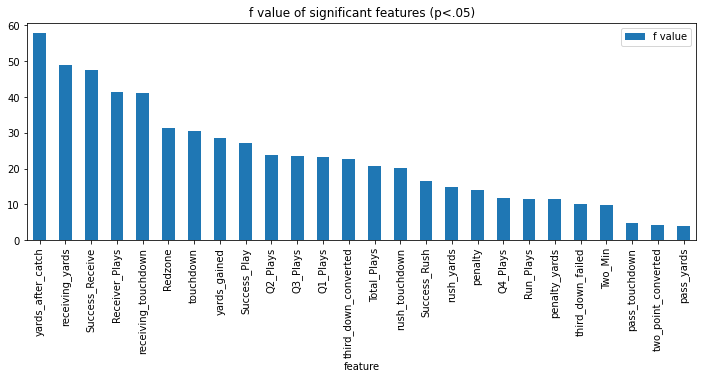

In [31]:
ftest_sig = ftest_all[ftest_all['p-value'] <= .05].sort_values('f value', ascending=False)
print(len(ftest_sig))
ftest_plot = ftest_sig.head(50)
ftest_plot.plot.bar(x='feature', y='f value', title='f value of significant features (p<.05)', figsize=(12,4))